In [1]:
# Federated Learning from scratch (FedAvg) — numpy implementation 
# This code creates a simple federated learning simulation using logistic regression (binary classification).
# - No external ML libraries required (only numpy, matplotlib)
# - Simulates non-iid data across clients
# - Implements FedAvg: local client SGD updates, server averages parameters weighted by client data sizes
# - Plots training loss and test accuracy


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
np.random.seed(69)



In [2]:

# Utilities: model, loss, grads

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict_proba(X, params):
    W, b = params['W'], params['b']
    return sigmoid(X.dot(W) + b)

def predict_label(X, params, threshold=0.5):
    return (predict_proba(X, params) >= threshold).astype(int)

def bce_loss(y_true, y_prob, eps=1e-12):
    y_prob = np.clip(y_prob, eps, 1-eps)
    return -np.mean(y_true * np.log(y_prob) + (1-y_true)*np.log(1-y_prob))

def compute_grads(X, y, params):
    # returns gradients for W and b (mean over samples)
    N = X.shape[0]
    probs = predict_proba(X, params)
    error = probs - y  # shape (N,)
    grad_W = (X.T.dot(error)) / N  # (d,)
    grad_b = np.mean(error)
    return {'W': grad_W, 'b': grad_b}



# Synthetic non-iid dataset

def make_non_iid_data(num_clients=5, samples_per_client=200, dim=10, non_iid_strength=0.9):
    """
    Creates binary classification data across clients.
    Each client has a local linear separator with some shared global direction
    non_iid_strength in [0,1] controls how different each client's separator is:
      0 -> identical across clients (iid)
      1 -> totally different per client
    """
    total = num_clients * samples_per_client
    # Global direction
    global_dir = np.random.randn(dim)
    global_dir /= np.linalg.norm(global_dir)
    
    X_all = []
    y_all = []
    client_partitions = []
    for c in range(num_clients):
        # local direction is a mix of global_dir and a random vector
        local_random = np.random.randn(dim)
        local_random /= np.linalg.norm(local_random)
        dir_c = (1 - non_iid_strength) * global_dir + non_iid_strength * local_random
        dir_c /= np.linalg.norm(dir_c)
        # Sample features
        Xc = np.random.randn(samples_per_client, dim)
        # make label according to linear separator with some noise
        logits = Xc.dot(dir_c) + 0.2 * np.random.randn(samples_per_client)
        yc = (logits > 0).astype(int)
        start = len(X_all)
        X_all.append(Xc)
        y_all.append(yc)
        client_partitions.append((start, start + samples_per_client))
    # Stack
    X_all = np.vstack(X_all)
    y_all = np.hstack(y_all)
    # Shuffle globally and create a test set holdout
    idx = np.random.permutation(total)
    X_all = X_all[idx]
    y_all = y_all[idx]
    # split: 80% train (distributed), 20% test (centralized)
    split = int(0.8 * total)
    X_train = X_all[:split]
    y_train = y_all[:split]
    X_test = X_all[split:]
    y_test = y_all[split:]
    # To provide client-local views, slice from original per-client arrays (not shuffled)
    # We'll re-create per-client local datasets from the original generation to preserve non-iid partitions.
    client_data = []
    for c in range(num_clients):
        Xc = X_all[c * samples_per_client:(c+1) * samples_per_client]
        yc = y_all[c * samples_per_client:(c+1) * samples_per_client]
        client_data.append((Xc, yc))
    return client_data, (X_test, y_test)



# Local client training routine

def local_train(X, y, params, local_epochs=1, batch_size=16, lr=0.1):
    """
    Performs local SGD (logistic regression) on the client's data.
    Returns updated params and number of samples.
    """
    W = params['W'].copy()
    b = params['b']
    N = X.shape[0]
    indices = np.arange(N)
    for ep in range(local_epochs):
        np.random.shuffle(indices)
        for i in range(0, N, batch_size):
            batch_idx = indices[i:i+batch_size]
            Xb = X[batch_idx]
            yb = y[batch_idx]
            grads = compute_grads(Xb, yb, {'W': W, 'b': b})
            W -= lr * grads['W']
            b -= lr * grads['b']
    return {'W': W, 'b': b}, N



# Federated training (FedAvg)

def federated_train(client_data, test_data, rounds=30, clients_per_round=None,
                    local_epochs=1, batch_size=16, lr=0.1, eval_every=1):
    num_clients = len(client_data)
    dim = client_data[0][0].shape[1]
    # initialize global params
    global_params = {'W': np.zeros(dim), 'b': 0.0}
    history = {'round': [], 'test_loss': [], 'test_acc': []}
    
    if clients_per_round is None:
        clients_per_round = num_clients  # full participation by default
    
    for r in range(1, rounds+1):
        # sample clients for this round
        selected = np.random.choice(num_clients, clients_per_round, replace=False)
        local_updates = []
        local_sizes = []
        for c in selected:
            Xc, yc = client_data[c]
            updated_params, Nc = local_train(Xc, yc, global_params, local_epochs=local_epochs,
                                             batch_size=batch_size, lr=lr)
            local_updates.append(updated_params)
            local_sizes.append(Nc)
        # aggregate (weighted average by client data size)
        total_samples = sum(local_sizes)
        W_new = np.zeros_like(global_params['W'])
        b_new = 0.0
        for upd, sz in zip(local_updates, local_sizes):
            W_new += (sz / total_samples) * upd['W']
            b_new += (sz / total_samples) * upd['b']
        global_params = {'W': W_new, 'b': b_new}
        
        # evaluate
        if r % eval_every == 0:
            X_test, y_test = test_data
            probs = predict_proba(X_test, global_params)
            loss = bce_loss(y_test, probs)
            preds = (probs >= 0.5).astype(int)
            acc = accuracy_score(y_test, preds)
            history['round'].append(r)
            history['test_loss'].append(loss)
            history['test_acc'].append(acc)
            print(f"Round {r:03d} | Test loss: {loss:.4f} | Test acc: {acc:.4f}")
    return global_params, history



Round 002 | Test loss: 0.6843 | Test acc: 0.5475
Round 004 | Test loss: 0.6862 | Test acc: 0.5442
Round 006 | Test loss: 0.6802 | Test acc: 0.5583
Round 008 | Test loss: 0.6914 | Test acc: 0.5250
Round 010 | Test loss: 0.6794 | Test acc: 0.5600
Round 012 | Test loss: 0.6876 | Test acc: 0.5292
Round 014 | Test loss: 0.6774 | Test acc: 0.5708
Round 016 | Test loss: 0.6893 | Test acc: 0.5425
Round 018 | Test loss: 0.6962 | Test acc: 0.5425
Round 020 | Test loss: 0.6928 | Test acc: 0.5450
Round 022 | Test loss: 0.6969 | Test acc: 0.5233
Round 024 | Test loss: 0.6953 | Test acc: 0.5208
Round 026 | Test loss: 0.6815 | Test acc: 0.5650
Round 028 | Test loss: 0.6871 | Test acc: 0.5350
Round 030 | Test loss: 0.6845 | Test acc: 0.5625
Round 032 | Test loss: 0.6902 | Test acc: 0.5383
Round 034 | Test loss: 0.6776 | Test acc: 0.5758
Round 036 | Test loss: 0.6802 | Test acc: 0.5617
Round 038 | Test loss: 0.6877 | Test acc: 0.5500
Round 040 | Test loss: 0.6830 | Test acc: 0.5558
Round 042 | Test los

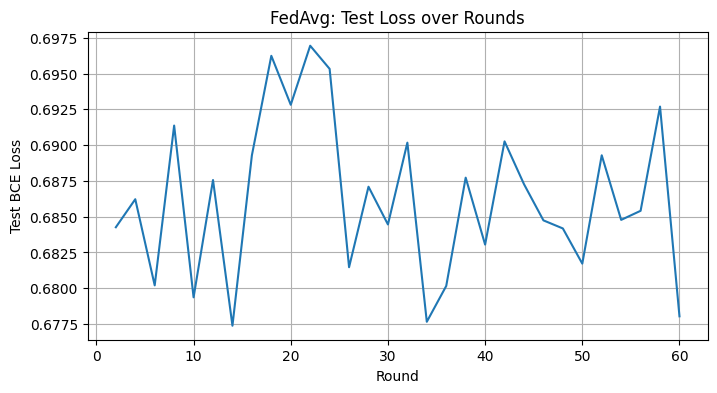

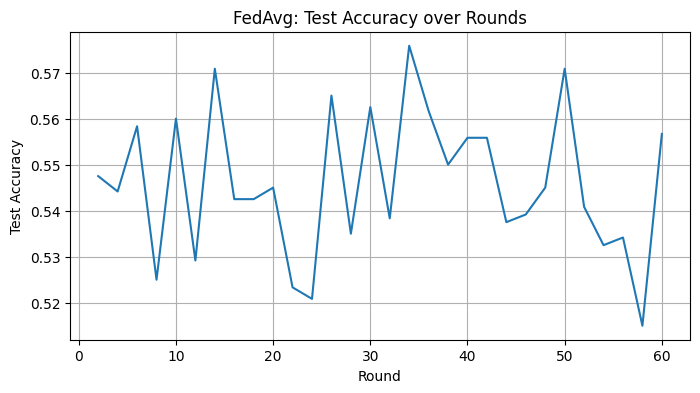


Final federated model -- Test loss: 0.6780 | Test acc: 0.5567


In [3]:


num_clients = 20
samples_per_client = 300
dim = 12
client_data, test_data = make_non_iid_data(num_clients=num_clients,
                                           samples_per_client=samples_per_client,
                                           dim=dim,
                                           non_iid_strength=0.9)

# Hyperparams
rounds = 60
clients_per_round = 4   # partial participation
local_epochs = 3
batch_size = 32
lr = 0.5

global_params, history = federated_train(client_data, test_data,
                                         rounds=rounds,
                                         clients_per_round=clients_per_round,
                                         local_epochs=local_epochs,
                                         batch_size=batch_size,
                                         lr=lr,
                                         eval_every=2)

# Baseline: centralized training on same total data for comparison
X_central = np.vstack([c[0] for c in client_data])
y_central = np.hstack([c[1] for c in client_data])

def centralized_train(X, y, test_data, epochs=50, batch_size=64, lr=0.1):
    dim = X.shape[1]
    params = {'W': np.zeros(dim), 'b': 0.0}
    N = X.shape[0]
    indices = np.arange(N)
    for ep in range(epochs):
        np.random.shuffle(indices)
        for i in range(0, N, batch_size):
            batch_idx = indices[i:i+batch_size]
            Xb = X[batch_idx]
            yb = y[batch_idx]
            grads = compute_grads(Xb, yb, params)
            params['W'] -= lr * grads['W']
            params['b'] -= lr * grads['b']
    # eval
    probs = predict_proba(test_data[0], params)
    loss = bce_loss(test_data[1], probs)
    acc = accuracy_score(test_data[1], (probs>=0.5).astype(int))
    return params, loss, acc

central_params, cent_loss, cent_acc = centralized_train(X_central, y_central, test_data,
                                                        epochs=200, batch_size=64, lr=0.1)
print("\nCentralized baseline -- Test loss: {:.4f} | Test acc: {:.4f}".format(cent_loss, cent_acc))


# Plots: test loss and accuracy

plt.figure(figsize=(8,4))
plt.plot(history['round'], history['test_loss'])
plt.xlabel('Round')
plt.ylabel('Test BCE Loss')
plt.title('FedAvg: Test Loss over Rounds')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history['round'], history['test_acc'])
plt.xlabel('Round')
plt.ylabel('Test Accuracy')
plt.title('FedAvg: Test Accuracy over Rounds')
plt.grid(True)
plt.show()

# Print final numbers
final_probs = predict_proba(test_data[0], global_params)
final_loss = bce_loss(test_data[1], final_probs)
final_acc = accuracy_score(test_data[1], (final_probs>=0.5).astype(int))
print(f"\nFinal federated model -- Test loss: {final_loss:.4f} | Test acc: {final_acc:.4f}")



# Client Selection Strategies Experiments

In this section, we'll compare different client selection strategies for federated learning:

1. **Random Selection**: Uniform random sampling (baseline, already used above)
2. **Power-of-Choice (PoC)**: Sample from a larger candidate pool and select best k
3. **Loss-based Selection**: Prioritize clients with higher local loss
4. **Gradient Norm Selection**: Select clients with larger gradient magnitudes
5. **Cyclic Selection**: Deterministic round-robin through all clients
6. **Data Size Weighted**: Probability proportional to client data size

We'll run each strategy and compare convergence speed and final accuracy.

In [4]:
# Enhanced federated training with different client selection strategies

def compute_client_loss(X, y, params):
    """Compute loss for a specific client's data"""
    probs = predict_proba(X, params)
    return bce_loss(y, probs)

def compute_gradient_norm(X, y, params):
    """Compute L2 norm of gradients for client data"""
    grads = compute_grads(X, y, params)
    return np.sqrt(np.sum(grads['W']**2) + grads['b']**2)


def federated_train_with_selection(client_data, test_data, 
                                   selection_strategy='random',
                                   rounds=30, clients_per_round=None,
                                   local_epochs=1, batch_size=16, lr=0.1, 
                                   eval_every=1, poc_pool_size=None):
    """
    Federated training with various client selection strategies.
    
    Args:
        selection_strategy: one of ['random', 'power_of_choice', 'loss_based', 
                                    'gradient_norm', 'cyclic', 'data_weighted']
        poc_pool_size: for power-of-choice, size of candidate pool (default: 2*clients_per_round)
    """
    num_clients = len(client_data)
    dim = client_data[0][0].shape[1]
    global_params = {'W': np.zeros(dim), 'b': 0.0}
    history = {'round': [], 'test_loss': [], 'test_acc': [], 'selected_clients': []}
    
    if clients_per_round is None:
        clients_per_round = num_clients
    
    if poc_pool_size is None:
        poc_pool_size = min(2 * clients_per_round, num_clients)
    
    # For cyclic selection
    cyclic_counter = 0
    
    for r in range(1, rounds+1):
        # CLIENT SELECTION based on strategy
        if selection_strategy == 'random':
            # Uniform random sampling
            selected = np.random.choice(num_clients, clients_per_round, replace=False)
            
        elif selection_strategy == 'power_of_choice':
            # Sample a larger pool, compute losses, select clients with highest loss
            candidates = np.random.choice(num_clients, poc_pool_size, replace=False)
            candidate_losses = []
            for c in candidates:
                Xc, yc = client_data[c]
                loss = compute_client_loss(Xc, yc, global_params)
                candidate_losses.append(loss)
            # Select top-k clients with highest loss
            top_k_indices = np.argsort(candidate_losses)[-clients_per_round:]
            selected = candidates[top_k_indices]
            
        elif selection_strategy == 'loss_based':
            # Compute loss for all clients, select top-k with highest loss
            client_losses = []
            for c in range(num_clients):
                Xc, yc = client_data[c]
                loss = compute_client_loss(Xc, yc, global_params)
                client_losses.append(loss)
            selected = np.argsort(client_losses)[-clients_per_round:]
            
        elif selection_strategy == 'gradient_norm':
            # Select clients with largest gradient norms
            grad_norms = []
            for c in range(num_clients):
                Xc, yc = client_data[c]
                norm = compute_gradient_norm(Xc, yc, global_params)
                grad_norms.append(norm)
            selected = np.argsort(grad_norms)[-clients_per_round:]
            
        elif selection_strategy == 'cyclic':
            # Round-robin selection
            selected = []
            for i in range(clients_per_round):
                selected.append(cyclic_counter % num_clients)
                cyclic_counter += 1
            selected = np.array(selected)
            
        elif selection_strategy == 'data_weighted':
            # Probability proportional to data size
            data_sizes = np.array([len(client_data[c][1]) for c in range(num_clients)])
            probs = data_sizes / data_sizes.sum()
            selected = np.random.choice(num_clients, clients_per_round, replace=False, p=probs)
        
        else:
            raise ValueError(f"Unknown selection strategy: {selection_strategy}")
        
        # LOCAL TRAINING on selected clients
        local_updates = []
        local_sizes = []
        for c in selected:
            Xc, yc = client_data[c]
            updated_params, Nc = local_train(Xc, yc, global_params, 
                                           local_epochs=local_epochs,
                                           batch_size=batch_size, lr=lr)
            local_updates.append(updated_params)
            local_sizes.append(Nc)
        
        # AGGREGATION (weighted average)
        total_samples = sum(local_sizes)
        W_new = np.zeros_like(global_params['W'])
        b_new = 0.0
        for upd, sz in zip(local_updates, local_sizes):
            W_new += (sz / total_samples) * upd['W']
            b_new += (sz / total_samples) * upd['b']
        global_params = {'W': W_new, 'b': b_new}
        
        # EVALUATION
        if r % eval_every == 0:
            X_test, y_test = test_data
            probs = predict_proba(X_test, global_params)
            loss = bce_loss(y_test, probs)
            preds = (probs >= 0.5).astype(int)
            acc = accuracy_score(y_test, preds)
            history['round'].append(r)
            history['test_loss'].append(loss)
            history['test_acc'].append(acc)
            history['selected_clients'].append(selected.tolist())
            
    return global_params, history

In [5]:
# Run experiments with different selection strategies

strategies = ['random', 'power_of_choice', 'loss_based', 'gradient_norm', 'cyclic', 'data_weighted']
results = {}

# Common hyperparameters for fair comparison
exp_rounds = 50
exp_clients_per_round = 4
exp_local_epochs = 3
exp_batch_size = 32
exp_lr = 0.5

print("Running client selection experiments...\n")
print("="*70)

for strategy in strategies:
    print(f"\n>>> Training with {strategy} selection strategy...")
    params, hist = federated_train_with_selection(
        client_data, test_data,
        selection_strategy=strategy,
        rounds=exp_rounds,
        clients_per_round=exp_clients_per_round,
        local_epochs=exp_local_epochs,
        batch_size=exp_batch_size,
        lr=exp_lr,
        eval_every=2
    )
    results[strategy] = {
        'params': params,
        'history': hist,
        'final_loss': hist['test_loss'][-1],
        'final_acc': hist['test_acc'][-1]
    }
    print(f"    Final test loss: {hist['test_loss'][-1]:.4f}")
    print(f"    Final test acc:  {hist['test_acc'][-1]:.4f}")

print("\n" + "="*70)
print("\nExperiment Summary:")
print("-"*70)
print(f"{'Strategy':<20} {'Final Loss':<15} {'Final Acc':<15} {'Rounds to 80% Acc'}")
print("-"*70)

for strategy in strategies:
    hist = results[strategy]['history']
    final_loss = results[strategy]['final_loss']
    final_acc = results[strategy]['final_acc']
    
    # Find round when accuracy first exceeds 80%
    rounds_to_80 = "N/A"
    for i, acc in enumerate(hist['test_acc']):
        if acc >= 0.80:
            rounds_to_80 = hist['round'][i]
            break
    
    print(f"{strategy:<20} {final_loss:<15.4f} {final_acc:<15.4f} {rounds_to_80}")

print("-"*70)

Running client selection experiments...


>>> Training with random selection strategy...
    Final test loss: 0.6875
    Final test acc:  0.5433

>>> Training with power_of_choice selection strategy...
    Final test loss: 0.6988
    Final test acc:  0.5225

>>> Training with loss_based selection strategy...
    Final test loss: 0.6989
    Final test acc:  0.5242

>>> Training with gradient_norm selection strategy...
    Final test loss: 0.6989
    Final test acc:  0.5242

>>> Training with gradient_norm selection strategy...
    Final test loss: 0.6920
    Final test acc:  0.5342

>>> Training with cyclic selection strategy...
    Final test loss: 0.6741
    Final test acc:  0.5817

>>> Training with data_weighted selection strategy...
    Final test loss: 0.6850
    Final test acc:  0.5558


Experiment Summary:
----------------------------------------------------------------------
Strategy             Final Loss      Final Acc       Rounds to 80% Acc
---------------------------------

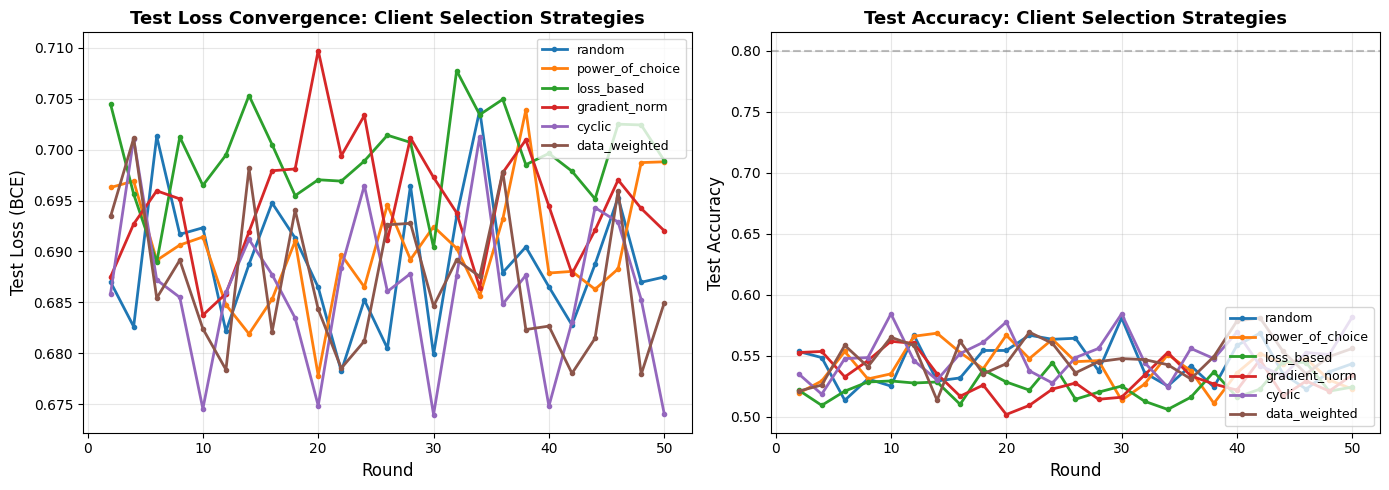

In [6]:
# Visualization: Compare convergence across strategies

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Test Loss over rounds
ax1 = axes[0]
for strategy in strategies:
    hist = results[strategy]['history']
    ax1.plot(hist['round'], hist['test_loss'], marker='o', markersize=3, label=strategy, linewidth=2)

ax1.set_xlabel('Round', fontsize=12)
ax1.set_ylabel('Test Loss (BCE)', fontsize=12)
ax1.set_title('Test Loss Convergence: Client Selection Strategies', fontsize=13, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Test Accuracy over rounds
ax2 = axes[1]
for strategy in strategies:
    hist = results[strategy]['history']
    ax2.plot(hist['round'], hist['test_acc'], marker='o', markersize=3, label=strategy, linewidth=2)

ax2.set_xlabel('Round', fontsize=12)
ax2.set_ylabel('Test Accuracy', fontsize=12)
ax2.set_title('Test Accuracy: Client Selection Strategies', fontsize=13, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0.8, color='gray', linestyle='--', alpha=0.5, label='80% threshold')

plt.tight_layout()
plt.show()

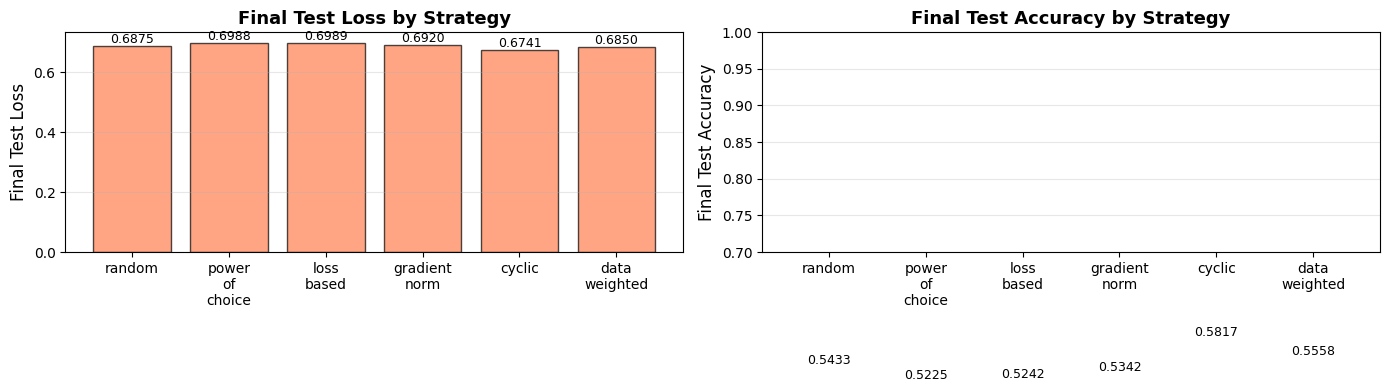

In [7]:
# Bar chart: Final performance comparison

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

strategies_labels = [s.replace('_', '\n') for s in strategies]
final_losses = [results[s]['final_loss'] for s in strategies]
final_accs = [results[s]['final_acc'] for s in strategies]

# Plot 1: Final Loss
ax1 = axes[0]
bars1 = ax1.bar(strategies_labels, final_losses, color='coral', edgecolor='black', alpha=0.7)
ax1.set_ylabel('Final Test Loss', fontsize=12)
ax1.set_title('Final Test Loss by Strategy', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Final Accuracy
ax2 = axes[1]
bars2 = ax2.bar(strategies_labels, final_accs, color='skyblue', edgecolor='black', alpha=0.7)
ax2.set_ylabel('Final Test Accuracy', fontsize=12)
ax2.set_title('Final Test Accuracy by Strategy', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0.7, 1.0])
# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

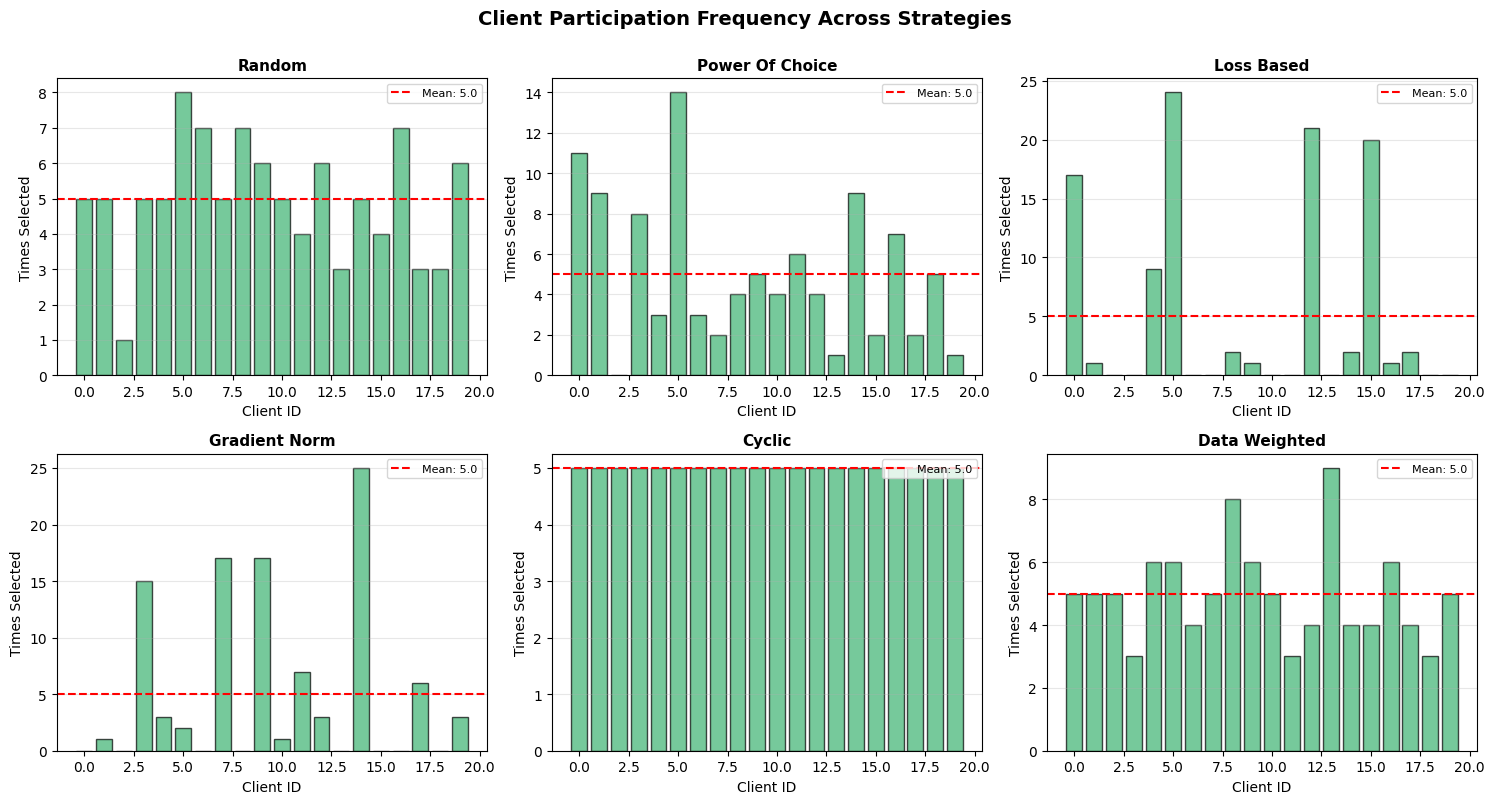


Client Participation Statistics:
Strategy             Mean       Std        Min        Max        Fairness (CV)
----------------------------------------------------------------------
random               5.00       1.64       1          8          0.3286
power_of_choice      5.00       3.59       0          14         0.7183
loss_based           5.00       8.07       0          24         1.6137
gradient_norm        5.00       7.23       0          25         1.4464
cyclic               5.00       0.00       5          5          0.0000
data_weighted        5.00       1.52       3          9          0.3033
----------------------------------------------------------------------
Note: Lower Coefficient of Variation (CV) indicates more uniform participation


In [8]:
# Analysis: Client participation frequency

def analyze_client_participation(history, num_clients):
    """Analyze which clients were selected and how often"""
    selected_clients_per_round = history['selected_clients']
    participation_count = np.zeros(num_clients)
    
    for round_clients in selected_clients_per_round:
        for client_id in round_clients:
            participation_count[client_id] += 1
    
    return participation_count

# Analyze participation for selected strategies
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, strategy in enumerate(strategies):
    hist = results[strategy]['history']
    participation = analyze_client_participation(hist, num_clients)
    
    ax = axes[idx]
    ax.bar(range(num_clients), participation, color='mediumseagreen', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Client ID', fontsize=10)
    ax.set_ylabel('Times Selected', fontsize=10)
    ax.set_title(f'{strategy.replace("_", " ").title()}', fontsize=11, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add stats
    mean_participation = participation.mean()
    std_participation = participation.std()
    ax.axhline(y=mean_participation, color='red', linestyle='--', linewidth=1.5, 
               label=f'Mean: {mean_participation:.1f}')
    ax.legend(fontsize=8, loc='upper right')

plt.suptitle('Client Participation Frequency Across Strategies', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Print participation statistics
print("\nClient Participation Statistics:")
print("="*70)
print(f"{'Strategy':<20} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10} {'Fairness (CV)'}")
print("-"*70)

for strategy in strategies:
    hist = results[strategy]['history']
    participation = analyze_client_participation(hist, num_clients)
    mean_p = participation.mean()
    std_p = participation.std()
    min_p = participation.min()
    max_p = participation.max()
    cv = std_p / mean_p if mean_p > 0 else 0  # Coefficient of variation (lower = more fair)
    
    print(f"{strategy:<20} {mean_p:<10.2f} {std_p:<10.2f} {min_p:<10.0f} {max_p:<10.0f} {cv:.4f}")

print("-"*70)
print("Note: Lower Coefficient of Variation (CV) indicates more uniform participation")

## Extended Experiment: Impact of Selection Fraction

Now let's study how the fraction of clients selected per round affects performance for different strategies.

In [9]:
# Experiment: varying client selection fraction

selection_fractions = [0.1, 0.2, 0.3, 0.5, 1.0]  # fraction of total clients
strategies_to_compare = ['random', 'loss_based', 'gradient_norm']

fraction_results = {s: {} for s in strategies_to_compare}

print("Running experiments with varying client selection fractions...\n")

for strategy in strategies_to_compare:
    print(f"\n>>> Strategy: {strategy}")
    for frac in selection_fractions:
        k = max(1, int(frac * num_clients))  # at least 1 client
        print(f"    Fraction: {frac:.1f} (k={k} clients)...", end=" ")
        
        params, hist = federated_train_with_selection(
            client_data, test_data,
            selection_strategy=strategy,
            rounds=40,
            clients_per_round=k,
            local_epochs=3,
            batch_size=32,
            lr=0.5,
            eval_every=5
        )
        
        fraction_results[strategy][frac] = {
            'params': params,
            'history': hist,
            'final_loss': hist['test_loss'][-1],
            'final_acc': hist['test_acc'][-1]
        }
        print(f"Final acc: {hist['test_acc'][-1]:.4f}")

print("\nDone!")

Running experiments with varying client selection fractions...


>>> Strategy: random
    Fraction: 0.1 (k=2 clients)... Final acc: 0.5142
    Fraction: 0.2 (k=4 clients)... Final acc: 0.5517
    Fraction: 0.3 (k=6 clients)... Final acc: 0.5575
    Fraction: 0.5 (k=10 clients)... Final acc: 0.5508
    Fraction: 1.0 (k=20 clients)... Final acc: 0.5508
    Fraction: 1.0 (k=20 clients)... Final acc: 0.5717

>>> Strategy: loss_based
    Fraction: 0.1 (k=2 clients)... Final acc: 0.5158
    Fraction: 0.2 (k=4 clients)... Final acc: 0.5250
    Fraction: 0.3 (k=6 clients)... Final acc: 0.5342
    Fraction: 0.5 (k=10 clients)... Final acc: 0.5717

>>> Strategy: loss_based
    Fraction: 0.1 (k=2 clients)... Final acc: 0.5158
    Fraction: 0.2 (k=4 clients)... Final acc: 0.5250
    Fraction: 0.3 (k=6 clients)... Final acc: 0.5342
    Fraction: 0.5 (k=10 clients)... Final acc: 0.5358
    Fraction: 1.0 (k=20 clients)... Final acc: 0.5358
    Fraction: 1.0 (k=20 clients)... Final acc: 0.5642

>>> St

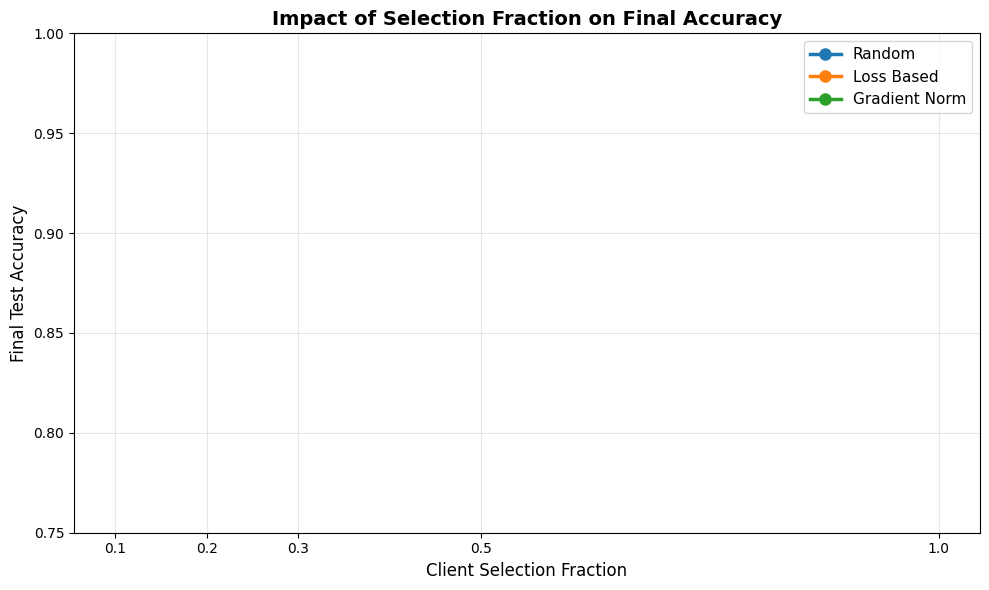


Selection Fraction Impact Summary:
Strategy             k=2         k=4         k=6         k=10        k=20        
--------------------------------------------------------------------------------
random               0.5142      0.5517      0.5575      0.5508      0.5717      
loss_based           0.5158      0.5250      0.5342      0.5358      0.5642      
gradient_norm        0.5375      0.5292      0.5708      0.5492      0.5633      


In [10]:
# Plot: Impact of selection fraction on final accuracy

plt.figure(figsize=(10, 6))

for strategy in strategies_to_compare:
    accs = [fraction_results[strategy][frac]['final_acc'] for frac in selection_fractions]
    plt.plot(selection_fractions, accs, marker='o', markersize=8, 
             linewidth=2.5, label=strategy.replace('_', ' ').title())

plt.xlabel('Client Selection Fraction', fontsize=12)
plt.ylabel('Final Test Accuracy', fontsize=12)
plt.title('Impact of Selection Fraction on Final Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(selection_fractions)
plt.ylim([0.75, 1.0])

# Add annotations
for strategy in strategies_to_compare:
    accs = [fraction_results[strategy][frac]['final_acc'] for frac in selection_fractions]
    # Annotate the 0.2 point (interesting regime)
    idx = 1  # 0.2 fraction
    plt.annotate(f'{accs[idx]:.3f}', 
                xy=(selection_fractions[idx], accs[idx]),
                xytext=(10, -5), textcoords='offset points',
                fontsize=9, alpha=0.7)

plt.tight_layout()
plt.show()

# Summary table
print("\nSelection Fraction Impact Summary:")
print("="*80)
print(f"{'Strategy':<20} ", end="")
for frac in selection_fractions:
    print(f"{'k=' + str(int(frac*num_clients)):<12}", end="")
print()
print("-"*80)

for strategy in strategies_to_compare:
    print(f"{strategy:<20} ", end="")
    for frac in selection_fractions:
        acc = fraction_results[strategy][frac]['final_acc']
        print(f"{acc:<12.4f}", end="")
    print()
print("="*80)

## Key Insights and Takeaways

### Summary of Client Selection Strategies:

1. **Random Selection**: Baseline approach with uniform sampling. Simple and unbiased but may select uninformative clients.

2. **Power-of-Choice**: Samples a larger candidate pool and selects clients with highest loss. Balances exploration with targeted selection.

3. **Loss-based Selection**: Always selects clients with highest local loss. Can accelerate convergence but may ignore well-performing clients.

4. **Gradient Norm Selection**: Prioritizes clients with larger gradient magnitudes. Targets clients that would make bigger updates.

5. **Cyclic Selection**: Deterministic round-robin ensuring all clients participate equally. Guarantees fairness but lacks adaptivity.

6. **Data-weighted Selection**: Probability proportional to data size. Favors clients with more data, potentially improving sample efficiency.

### Trade-offs:
- **Convergence speed** vs **Fairness**: Adaptive strategies (loss-based, gradient) may converge faster but create unequal participation
- **Communication cost**: Strategies requiring loss/gradient computation on all clients have overhead
- **Robustness**: Random and cyclic are more robust to changing data distributions
- **Client selection fraction**: Higher fractions generally improve accuracy but increase communication costs

### Recommendations:
- For **fast convergence**: Use loss-based or gradient norm selection
- For **fairness**: Use cyclic or random selection
- For **balanced performance**: Use power-of-choice (good middle ground)
- **Optimal fraction**: 20-30% of clients often provides good trade-off between performance and efficiency